# New Hotel in Milan

----

## Table of Contents

1.  <a href="#item1">Introduction / Business Problem</a>
2.  <a href="#item2">Data</a>
3.  <a href="#item2">Methodology</a>
4.  <a href="#item2">Analysis</a>
5.  <a href="#item2">Results and Discussion</a>
6.  <a href="#item2">Conclusion</a>

### Import needed dependencies

In [24]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import shapefile #library to handle shapefile

!pip install geopandas #uncomment this line if installation is needed
import geopandas as gpd  #library to read geofiles, used to convert polygon data to point

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## 1. Introduction / Business Problem

After the 2015 Expo, Milan is on the rise. The city is growing very fast and also its appeal to tourists and businessmen. For this reason, a new investor from abroad wants to open a brand new hotel in town. He doesn't know the city, so he wants to understand which are the best locations to look at.

Prior to collecting any data we have a conversation, where we talk about what "best location" means to him. The investor is an art expert and wants to build a hotel that talks about his passion for art. For this reason he believes his hotel should be **near a Metro Station** and with enough **Arts & Entertainment** venues nearby. From this analysis he expects me to give him a **top-three list of best Milan Neighborhoods** for his hotel location, so he can proceed in contacting relevant stakeholders.

## 2. Data

Now that the business problem is clearly defined, we know which data we need:

1. List of Neighborhoods in Milan
2. List of Metro Station and Arts & Entertainment venues

For point 1 we will scrape Neighborhoods list from the Milan Municipality website, while for point 2 we will use the Foursquare API.

### Get Milan Neighborhoods

From the Milan town website, a csv list of all neighborhoods is available for download

In [3]:
!wget -q -O 'milan_neigh.csv' https://dati.comune.milano.it/dataset/e8e765fc-d882-40b8-95d8-16ff3d39eb7c/resource/3fce7202-0076-4a7b-ac2c-d2ab9b5dc658/download/ds964_nil_wm_.csv
print('Data downloaded!')

Data downloaded!


In [4]:
import pandas as pd

milan_neigh = pd.read_csv('milan_neigh.csv', sep=';')

print('dataframe shape is ',milan_neigh.shape)
milan_neigh.head()

dataframe shape is  (88, 8)


,ID_NIL,NIL,Valido_dal,Valido_al,Fonte,Shape_Length,Shape_Area,OBJECTID
0,48,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,8723.368714,2.406306e+06,89
1,64,TRENNO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,3309.998800,4.896921e+05,90
2,67,PORTELLO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,3800.750663,9.096022e+05,91
3,81,BOVISASCA,05/02/2020,Vigente,Milano 2030 - PGT Approvato,7105.469715,1.578028e+06,92
4,84,PARCO NORD,05/02/2020,Vigente,Milano 2030 - PGT Approvato,11741.717005,1.532331e+06,93


From the same website, we can find also the geojson file and a .zip folder which contains shapefiles. Since the geojson files contains polygon coordinates, for the purpose of this analysis I will download the zip folder and use geopandas library to easily convert polygon into points.

In [5]:
sf = shapefile.Reader("NIL_WM.shp")
sf.shapeTypeName

'POLYGON'

In [6]:
# get geopanda dataframe with polygon information

polys = gpd.read_file("NIL_WM.shp")
polys.head()

,geometry
0,"POLYGON ((9.15422 45.43775, 9.15419 45.43707, ..."
1,"POLYGON ((9.10623 45.49016, 9.10295 45.48939, ..."
2,"POLYGON ((9.15636 45.48785, 9.15724 45.48721, ..."
3,"POLYGON ((9.16803 45.52234, 9.16687 45.52027, ..."
4,"POLYGON ((9.20040 45.52848, 9.20055 45.52828, ..."


In [7]:
#convert polygon to points

points = polys.copy()
points['geometry'] = points['geometry'].centroid
points.head()

,geometry
0,POINT (9.13726 45.43846)
1,POINT (9.10167 45.49282)
2,POINT (9.15395 45.48449)
3,POINT (9.15673 45.51743)
4,POINT (9.18424 45.52351)


Now that we have points, we need to create two columns, one for latitude and one for longitude. To do this, we can use pandas string split method:

In [8]:
coordinates = points.copy()
coordinates['geometry'] = coordinates['geometry'].astype(str).str.replace('(','').str.replace(')','')

coordinates[['Drop','Longitude','Latitude']] = coordinates.geometry.str.split(" ",expand=True)
coordinates = pd.DataFrame(coordinates[['Latitude','Longitude']]).astype(float)

print('data type is ', coordinates.dtypes)
print('df shape is ', coordinates.shape)
coordinates.head()

data type is  Latitude     float64
Longitude    float64
dtype: object
df shape is  (88, 2)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,Latitude,Longitude
0,45.438460,9.137260
1,45.492822,9.101675
2,45.484490,9.153947
3,45.517433,9.156731
4,45.523514,9.184235


Last steps are merging the csv and the points dataframe and keep in the dataframe only relevant columns:

In [9]:
df_milan = milan_neigh.join(coordinates)
df_milan = df_milan[['ID_NIL','NIL','Latitude','Longitude']]

print('df_milan shape is ', df_milan.shape)
df_milan.head()

df_milan shape is  (88, 4)


,ID_NIL,NIL,Latitude,Longitude
0,48,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.438460,9.137260
1,64,TRENNO,45.492822,9.101675
2,67,PORTELLO,45.484490,9.153947
3,81,BOVISASCA,45.517433,9.156731
4,84,PARCO NORD,45.523514,9.184235


Let's finally plot our results on map to see where these neighborhoods are located:

In [10]:
#get Milan coordinates using Nominatim
address = 'Milan, IT'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Milan are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Milan are 45.4668, 9.1905.


In [11]:
# create map of Milan using latitude and longitude values
map_milan = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_milan['Latitude'], df_milan['Longitude'], df_milan['NIL']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan)  
    
map_milan

### Get Metro Station and Arts & Entertainment venues

Now that we have collected information and location of each neighborhood, it's time to use the Foursquare API to get a list of Metro Station and Arts & Entertainment venues for every location

In [12]:
CLIENT_ID = 'E4ZUJLC4D1V1MTDEJ2LAZ0Y5GVLJ52IEPKAEEWCIWN3SUU5V' # your Foursquare ID
CLIENT_SECRET = 'PVK0GN0GLKEPDOCYMGTUU3RW5FMJ5R04II4MUH43IW3SPQQZ' # your Foursquare Secret
ACCESS_TOKEN = 'DPEWHV0D4D1MMUZHWUGLTBDNXEYCUAN3BE0TPSUBA1GX0GLS' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 300

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: E4ZUJLC4D1V1MTDEJ2LAZ0Y5GVLJ52IEPKAEEWCIWN3SUU5V
CLIENT_SECRET:PVK0GN0GLKEPDOCYMGTUU3RW5FMJ5R04II4MUH43IW3SPQQZ


To quickly get a list of Metro Station and Arts and Entertainment venues, we have adapted the formula created in the lab including categoryId as a parameter. In this way we can lower computational times and obtain a pre-filtered ready-to-use database:

In [13]:
def getNearbyVenues(names, latitudes, longitudes, categoryId, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            categoryId,
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

First I call the Metro station database:

In [14]:
milan_metro = getNearbyVenues(names=df_milan['NIL'], latitudes=df_milan['Latitude'], longitudes=df_milan['Longitude'], categoryId='4bf58dd8d48988d1fd931735', radius=1000)
milan_metro.head()

RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO
TRENNO
PORTELLO
BOVISASCA
PARCO NORD
FIGINO
LORETO - CASORETTO - NOLO
QUARTO OGGIARO - VIALBA - MUSOCCO
ISOLA
QUARTO CAGNINO
STADIO - IPPODROMI
QUINTO ROMANO
DUOMO
GUASTALLA
SAN SIRO
COMASINA
TIBALDI
GRECO - SEGNANO
DE ANGELI - MONTE ROSA
FARINI
BRUZZANO
QT 8
STEPHENSON
CANTALUPA
QUINTOSOLE
PARCO SEMPIONE
BARONA
VILLAPIZZONE - CAGNOLA - BOLDINASCO
PARCO BOSCO IN CITTA'
GORLA - PRECOTTO
NIGUARDA - CA' GRANDA - PRATO CENTENARO - Q.RE FULVIO TESTI
TRIULZO SUPERIORE
PTA ROMANA
TALIEDO - MORSENCHIO - Q.RE FORLANINI
PORTA TICINESE - CONCA DEL NAVIGLIO
TRE TORRI
ASSIANO
MORIVIONE
VIGENTINO - Q.RE FATIMA
BICOCCA
ORTOMERCATO
LODI - CORVETTO
MUGGIANO
PORTA TICINESE - CONCHETTA
UMBRIA - MOLISE - CALVAIRATE
ROSERIO
RONCHETTO DELLE RANE
Q.RE GALLARATESE - Q.RE SAN LEONARDO - LAMPUGNANO
MONLUE' - PONTE LAMBRO
PADOVA - TURRO - CRESCENZAGO
GRATOSOGLIO - Q.RE MISSAGLIA - Q.RE TERRAZZE
PORTA MAGENTA
FORZE ARMATE
GHISOLFA
CHIARAVALLE
PARCO DELLE ABBAZIE
MACI

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,TRENNO,45.492822,9.101675,Metro Bonola (M1),45.496913,9.110450,Metro Station
1,TRENNO,45.492822,9.101675,Metro San Leonardo (M1),45.501083,9.101400,Metro Station
2,PORTELLO,45.484490,9.153947,Metro Portello (M5),45.481807,9.150506,Metro Station
3,PORTELLO,45.484490,9.153947,Metro Tre Torri (M5),45.477957,9.156873,Metro Station
4,PORTELLO,45.484490,9.153947,Metro Domodossola FN (M5),45.481860,9.162487,Metro Station


In [15]:
print('df shape is ', milan_metro.shape)
milan_metro.insert(7,'Family','Metro')
milan_metro.head()

df shape is  (238, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Family
0,TRENNO,45.492822,9.101675,Metro Bonola (M1),45.496913,9.110450,Metro Station,Metro
1,TRENNO,45.492822,9.101675,Metro San Leonardo (M1),45.501083,9.101400,Metro Station,Metro
2,PORTELLO,45.484490,9.153947,Metro Portello (M5),45.481807,9.150506,Metro Station,Metro
3,PORTELLO,45.484490,9.153947,Metro Tre Torri (M5),45.477957,9.156873,Metro Station,Metro
4,PORTELLO,45.484490,9.153947,Metro Domodossola FN (M5),45.481860,9.162487,Metro Station,Metro


Then I create a second call for Arts venues:

In [16]:
milan_arts = getNearbyVenues(names=df_milan['NIL'], latitudes=df_milan['Latitude'], longitudes=df_milan['Longitude'], categoryId='4d4b7104d754a06370d81259', radius=1000)
milan_arts.head()

RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO
TRENNO
PORTELLO
BOVISASCA
PARCO NORD
FIGINO
LORETO - CASORETTO - NOLO
QUARTO OGGIARO - VIALBA - MUSOCCO
ISOLA
QUARTO CAGNINO
STADIO - IPPODROMI
QUINTO ROMANO
DUOMO
GUASTALLA
SAN SIRO
COMASINA
TIBALDI
GRECO - SEGNANO
DE ANGELI - MONTE ROSA
FARINI
BRUZZANO
QT 8
STEPHENSON
CANTALUPA
QUINTOSOLE
PARCO SEMPIONE
BARONA
VILLAPIZZONE - CAGNOLA - BOLDINASCO
PARCO BOSCO IN CITTA'
GORLA - PRECOTTO
NIGUARDA - CA' GRANDA - PRATO CENTENARO - Q.RE FULVIO TESTI
TRIULZO SUPERIORE
PTA ROMANA
TALIEDO - MORSENCHIO - Q.RE FORLANINI
PORTA TICINESE - CONCA DEL NAVIGLIO
TRE TORRI
ASSIANO
MORIVIONE
VIGENTINO - Q.RE FATIMA
BICOCCA
ORTOMERCATO
LODI - CORVETTO
MUGGIANO
PORTA TICINESE - CONCHETTA
UMBRIA - MOLISE - CALVAIRATE
ROSERIO
RONCHETTO DELLE RANE
Q.RE GALLARATESE - Q.RE SAN LEONARDO - LAMPUGNANO
MONLUE' - PONTE LAMBRO
PADOVA - TURRO - CRESCENZAGO
GRATOSOGLIO - Q.RE MISSAGLIA - Q.RE TERRAZZE
PORTA MAGENTA
FORZE ARMATE
GHISOLFA
CHIARAVALLE
PARCO DELLE ABBAZIE
MACI

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,FE Fabbrica Esperienza,45.442009,9.140764,Theater
1,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Scuola di danza Arteka ASD,45.442993,9.139563,Dance Studio
2,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Circo delle Pulci,45.443317,9.137659,Public Art
3,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Connecting Cultures,45.434962,9.131393,Arts & Entertainment
4,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Silverwhood,45.443533,9.129999,Music Venue


In [17]:
print('df shape is ', milan_arts.shape)
milan_arts.insert(7,'Family','Arts')
milan_arts.head()

df shape is  (760, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Family
0,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,FE Fabbrica Esperienza,45.442009,9.140764,Theater,Arts
1,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Scuola di danza Arteka ASD,45.442993,9.139563,Dance Studio,Arts
2,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Circo delle Pulci,45.443317,9.137659,Public Art,Arts
3,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Connecting Cultures,45.434962,9.131393,Arts & Entertainment,Arts
4,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,45.43846,9.13726,Silverwhood,45.443533,9.129999,Music Venue,Arts


Finally I create a unique database for all the venue categories I want to analyze:

In [18]:
milan_venues = milan_metro.append(milan_arts, ignore_index=True)
milan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Family
0,TRENNO,45.492822,9.101675,Metro Bonola (M1),45.496913,9.110450,Metro Station,Metro
1,TRENNO,45.492822,9.101675,Metro San Leonardo (M1),45.501083,9.101400,Metro Station,Metro
2,PORTELLO,45.484490,9.153947,Metro Portello (M5),45.481807,9.150506,Metro Station,Metro
3,PORTELLO,45.484490,9.153947,Metro Tre Torri (M5),45.477957,9.156873,Metro Station,Metro
4,PORTELLO,45.484490,9.153947,Metro Domodossola FN (M5),45.481860,9.162487,Metro Station,Metro


In [19]:
milan_venues.shape

(998, 8)

In [20]:
if milan_venues['Neighborhood'].count() == milan_arts['Neighborhood'].count() + milan_metro['Neighborhood'].count():
    print('Database append done correctly'),
else:
    print('Check and try again')

Database append done correctly


## 3. Methodology

In this project we want to detect neighborhoods which are closed to metro stations and have plenty of art venues.

In first step we have collected the required data: **location of every neighborhood and a list of arts and metro locations in those neighborhoods.**

Second step in our analysis will be calculation and exploration of 'arts and metro location density' across the given neighborhoods - we will use **heatmaps to identify the most promising areas, creating a top-three list of neighborhoods.**

*This list will be useful for further 'street level' exploration and search for optimal venue location by the stakeholder.*

## 4. Analysis

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the number of metro and arts venues in every neighborhood:

In [26]:
pivotTable = milan_venues.pivot_table(milan_venues, index=['Neighborhood'], columns=['Family'], aggfunc='count', fill_value=0)
pivotTable = pivotTable['Venue']
pivotTable.loc[:,'Total'] = pivotTable.sum(axis=1)
pivotTable.sort_values(by=['Total'],axis=0, ascending=False, inplace=True)
pivotTable.head(10)

Family,Arts,Metro,Total
Neighborhood,,,
DUOMO,55,15,70
BRERA,45,8,53
PORTA TICINESE - CONCHETTA,39,5,44
GIARDINI P.TA VENEZIA,35,7,42
PORTA GENOVA,35,4,39
GUASTALLA,32,7,39
MAGENTA - S. VITTORE,30,8,38
PARCO SEMPIONE,28,8,36
BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE,26,4,30


From this table we already get some useful insight. We have a top-10 list of neighborhoods per total number of venues. We see premium city center location like Duomo and Brera but also some neighborhoods little further.

We can make two histograms to show the frequency of Venue Family for each neighborhood:

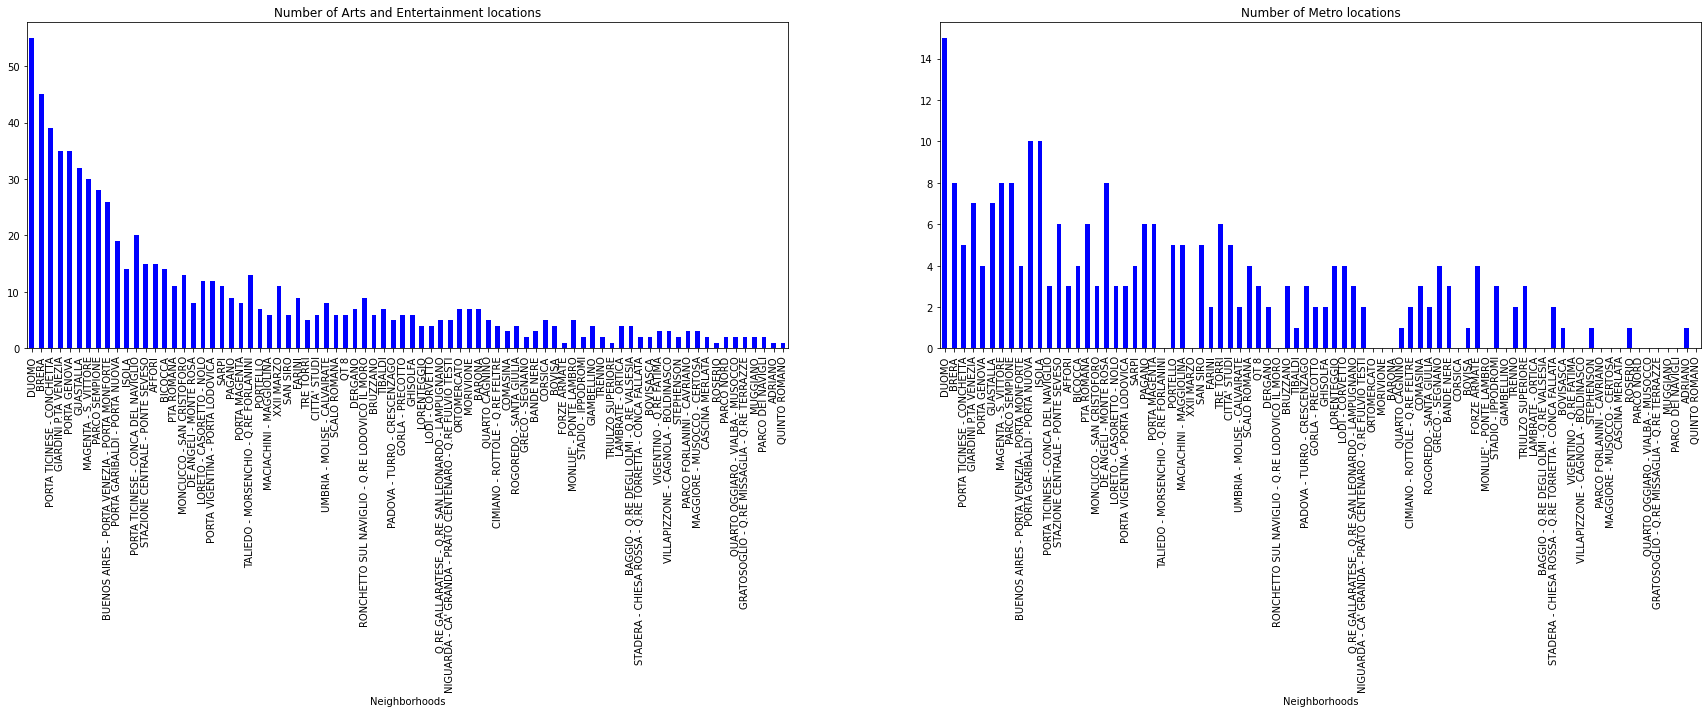

In [29]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
pivotTable['Arts'].plot(kind='bar', color='blue', figsize=(30, 6), ax=ax0) # add to subplot 1
ax0.set_title('Number of Arts and Entertainment locations')
ax0.set_xlabel('Neighborhoods')

# Subplot 2: Line plot
pivotTable['Metro'].plot(kind='bar', color='blue', figsize=(30, 6), ax=ax1)
ax1.set_title ('Number of Metro locations')
ax1.set_xlabel('Neighborhoods')

plt.show()

We can see not all neighborhoods have Metro stations and that several neighborhoods have a relevant coverage of both public transportation and Arts venues.

For the purpose of the analysis, we can use a **heatmap** to better address the density of Total number of venues. To do this we can use the geojson map we used in the data section to collect centroids, this time we will benefit from the polygonal information to design a choropleth map of neighborhoods:

In [22]:
milan_geo = r'ds964_NIL_WM.geojson'

milan_neigh_map = folium.Map(location=[latitude, longitude], zoom_start=11)

milan_neigh_map.choropleth(
    geo_data=milan_geo,
    data=pivotTable,
    columns=['Neighborhood', 'Total'],
    key_on='feature.properties.NIL',
    fill_color='YlGnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Density of Metro and Arts locations'
)

milan_neigh_map

Nice results, as predictable the most dense area is the city center but we get some density also in locations little further.

## 5. Results and Discussion


As the investor requested we got a top-3 list of neighborhoods with a relevant density of arts and metro locations where he can invest in a new hotel opening. The locations are:
+ Duomo
+ Brera
+ Porta Ticinese - Conchetta

At the moment the analysis is still on a high level. We could include existing hotel density to check if there are any streets or zones in theighborhoods without an hotel. For the purpose of this first stage the stakeholder wanted to start with an elicopter view to start searching for available buildings in relevant areas.

Using the Foursquare API and the municipality website we were able to leverage data in getting a proper list of neighborhoods and with Folium and Choropleth maps quickly identify the best locations.

## 6. Conclusion

Purpose of this project was to identify Milan neighborhoods with an high concentration of metro and arts and entertainment venues.

By calculating location density distribution from Foursquare data we created an heatmap to visually identify the best neighborhoods where to concentrate next effort to find an available building and then analyze further the existing hotels in the area to be sure the hotel has its own unique proposition.

Final decission on optimal hotel location will be made by the stakeholder based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location, real estate availability, prices, social and economic dynamics of every neighborhood etc.

*Thank you*